# **Multilabel- multioutput Sentiment Analysis VS ClassifierChain Sentiment**

# **Part 2:** Model Compariosions

The aim of this project is only comparison, not fine-tuning, and so for that, we are going to use the **RandomForestClassifier** as the base model for all of our trials with its default values.

Our Focus Here is to compare between:

- **MultiOutput Classifier:** This strategy consists of fitting one classifier per target.

- **Classifier Chain:** Combine a number of binary classifiers into a single multi-label model that is capable of exploiting correlations among targets.

<center> 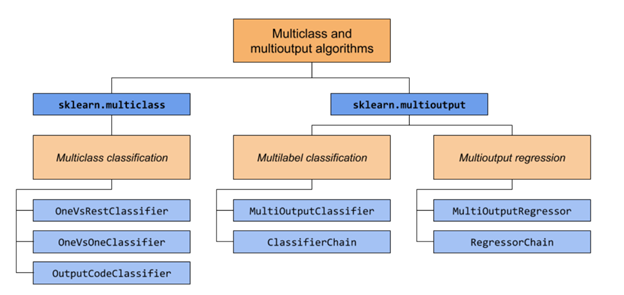


https://scikit-learn.org/stable/modules/multiclass.html#multioutput-regression








We first a Base Model For Tracking Improvments.
This Cycle is performed twice, one time without Emotions Class Reduction and the other trial iw with it

So, basically, once again, we have **"Multi-Label Multi-Output Classification"**:

Where our two predicted labels are:

- Label (Y) : indicates the if the review is a positive or negative.

- Emotion (Y1): indicates the emotions one has gotten from the review itself (admiration, disappointment, etc).


<font color=red> **Note:** </font>  The evaluation metric used in this experiment is ** weighted f1_score** which is the ideal for computing the net F1 score for class-imbalanced data distribution.




<center> 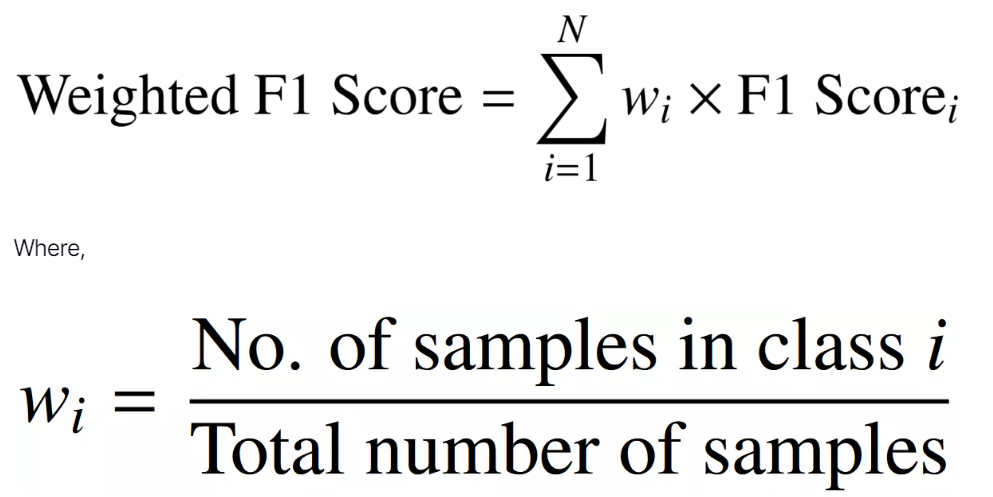


<br>

# **Step 0:** Install Dependencies

## `->` Install Dependencies

In [ ]:
!pip install nltk scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.8 MB/s eta 0:00:00


In [ ]:
# Preprocessing
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler

# Visulization
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from skmultilearn.problem_transform import ClassifierChain
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import f1_score, confusion_matrix, silhouette_score
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

# **Step 1:** Read Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filtered_data = pd.read_csv('/content/drive/MyDrive/ML_Datasets/Finaldata.csv')

print("filtered_data shape:", filtered_data.shape)
filtered_data.head(2)

filtered_data shape: (14878, 4)


,cleaned_title_text,cleaned_content_text,label,emotion
0,imposs clean paint chpped unsanitari,world would make toy babi slobber imposs clean...,0,approval
1,miss mark,best track pound prevent jenni tower way wasth...,0,disappointment


In [ ]:
# Final Data frame
# Create a column with merged text
x = filtered_data['cleaned_title_text'] +" "+ filtered_data['cleaned_content_text']

y = filtered_data[['label', 'emotion']]

# Optionally, print the shapes of the merged DataFrames
print("x shape:", x.shape)
print("y shape:", y.shape)

x shape: (14878,)
y shape: (14878, 2)


In [ ]:
x.head(2)

0    imposs clean paint chpped unsanitari world wou...
1    miss mark best track pound prevent jenni tower...
dtype: object

In [ ]:
y.head(2)

,label,emotion
0,0,approval
1,0,disappointment


## `->` Split Data, 80% Train and 20% Test

In [ ]:
Train_X, Test_X, Train_Y, Test_Y, Train_Y1, Test_Y1 = model_selection.train_test_split(x,
                                                                                       y['label'],y['emotion'],
                                                                                       test_size=0.2)

# **Step 2:** Data Preparation


- Vectorization
- Standarization
- Label Encoding



## `->` Vectorizer Data

In [ ]:
# Check The Original num of feature without any constrains
# Tfidf_vect =  TfidfVectorizer(min_df=3,  max_features=None,
#               ngram_range=(1, 3), stop_words = 'english').fit(x)
# Tfidf_vect.vocabulary_.__len__()

39220

In [ ]:
# we have tried values like 1,000 5,000, 10,000 initially and 1,000 was better
# Fit on Train
Tfidf_vect = TfidfVectorizer(min_df=3, max_features=1000, ngram_range=(1, 3), stop_words='english').fit(x)
# transform on Train and Test
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

## `->` Standarization

In [ ]:
# Fit on Train
scaler = StandardScaler().fit(Train_X_Tfidf.toarray())
# transform on Train and Test
scaled_Train_X = scaler.transform(Train_X_Tfidf.toarray())
scaled_Test_X = scaler.transform(Test_X_Tfidf.toarray())

print("scaled_Train_X shape :", scaled_Train_X.shape)

scaled_Train_X shape : (11902, 1000)


## `->` Encode Emotions Column

In [ ]:
# Fit on Train
encoder = LabelEncoder()
# transform on Train and Test
Encoded_Train_Y1 = encoder.fit_transform(Train_Y1)
Encoded_Test_Y1 = encoder.transform(Test_Y1)

# **Step 3:** Sub-Classes Handling

Capture 90% of the variance using PCA for some dimentionality reduction since the dimentions are so high.

## `->` Dimensionality Reduction

In [ ]:
# See how much 0.9 captured variance can PCA aquire and represent
pca = PCA(n_components=0.9, random_state=42)
reduced_X_Train = pca.fit_transform(scaled_Train_X)
reduced_X_Test = pca.transform(scaled_Test_X)

## `->` Find the best number of clusters k

### using **AgglomerativeClustering Model** silhouette scores

Clustering Progress: 100%|██████████| 7/7 [01:05<00:00,  9.37s/it]

[0.3766446, 0.3718804, 0.37270308, 0.3687422, 0.35081658, 0.33366385, 0.3235903]


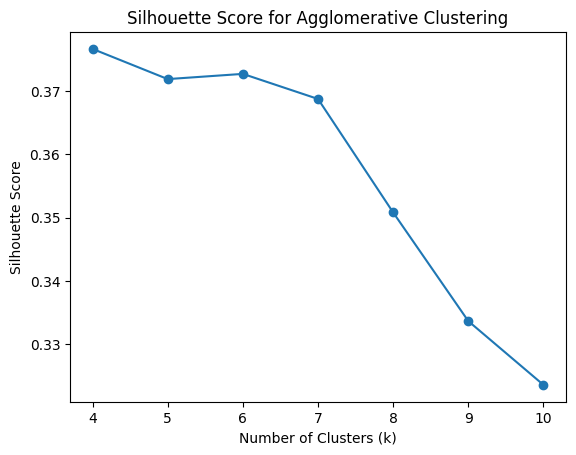

In [ ]:
# Perform Agglomerative Clustering with varying numbers of clusters
max_clusters = 10
silhouette_scores = []

# linkage=‘ward’ minimizes the variance of the clusters being merged.
for n_clusters in tqdm(range(4, max_clusters + 1), desc="Clustering Progress"):
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = agg_clustering.fit_predict(reduced_X_Train)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(reduced_X_Train, cluster_labels)
    silhouette_scores.append(silhouette_avg)

print(silhouette_scores)
# Plot the silhouette scores to determine the optimal number of clusters (k)
plt.plot(range(4, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Agglomerative Clustering')
plt.show()


### using **dendrogram**

In [ ]:
linked = linkage(reduced_X_Train, 'ward')

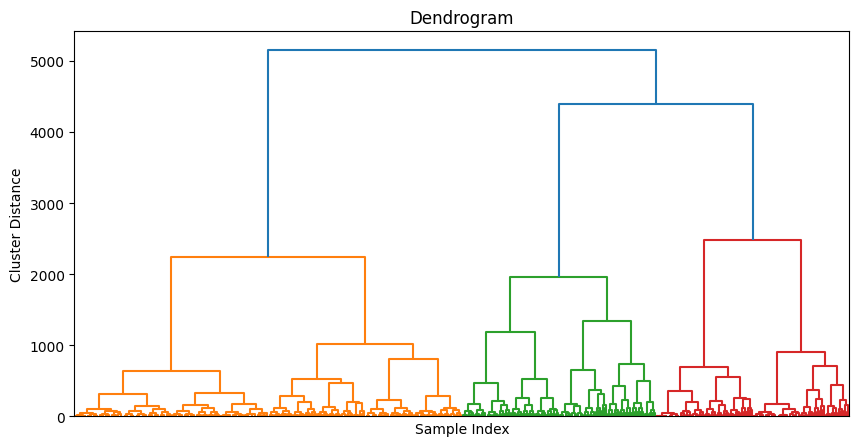

In [ ]:
plt.figure(figsize=(10, 5))

dendrogram(linked, show_leaf_counts=False, truncate_mode='level', no_labels=True, p=8)
plt.title('Dendrogram')
# Increase x-axis tick label font size
plt.tick_params(axis='x', labelsize=5)  # Adjust the labelsize as needed
plt.xlabel('Sample Index')
plt.ylabel('Cluster Distance')
plt.show()

Conclusion: I believe **6** clusters are worth trying

## `->`  Minimize the Number of Clusters by Merging Similar Emotion Themes Together

In [ ]:
# Try KMeans on 6 n_clusters
KMeans_clustering = KMeans(n_clusters=6, n_init = 10, random_state = 42)

# fit and Transform on Train
new_Train_Y1 = KMeans_clustering.fit_predict(reduced_X_Train)

# Transform on Test
new_Test_Y1 = KMeans_clustering.predict(reduced_X_Test)

In [ ]:
# Check if same emotions are in the same cluster
df_merged = pd.DataFrame({'predicted': new_Train_Y1, 'emotion': Train_Y1})
same_cluster = df_merged.groupby(['emotion', 'predicted']).size().unstack(fill_value=0)

# Rename emotion index names
same_cluster = same_cluster.rename(index=dict(zip(same_cluster.index, encoder.classes_)))

# Add a new column with the total number of rows
same_cluster['total'] = same_cluster.sum(axis=1)

print("Same Emotions in Same Cluster:")
print(same_cluster)



Same Emotions in Same Cluster:
predicted         0    1    2    3    4    5  total
emotion                                            
admiration      411  570  389  375  306  340   2391
amusement        26   32   36  127   46   11    278
annoyance        66   97  137  228  127  116    771
approval        194   78   89   47   84  240    732
confusion        57   25   61   23   28   54    248
curiosity        26   37   40   29   31   18    181
disappointment  233  306  506  380  270  542   2237
disapproval     175  133  149  145  187  331   1120
disgust          12   24   32   81   30   19    198
gratitude        33   36   33   19   39   61    221
joy              87   70  197   62  102   90    608
love             92  143  190   83  178  103    789
neutral         413  257  213  168  365  712   2128


Here, we can see the occurrence of each emotion in the six reduced clusters. We can say by eye that these clusters could be represented by the following since they are the most common:

> 0:approval
>
> 1:admiration
>
> 2:disappointment
>
> 3:annoyance
>
> 4:disapproval
>
> 5:neutral


In [ ]:
# Mapping of cluster labels to emotions
label_mapping = {
    0: 'approval',
    1: 'admiration',
    2: 'disappointment',
    3: 'annoyance',
    4: 'disapproval',
    5: 'neutral'
}


## Check Imbalance and downsample

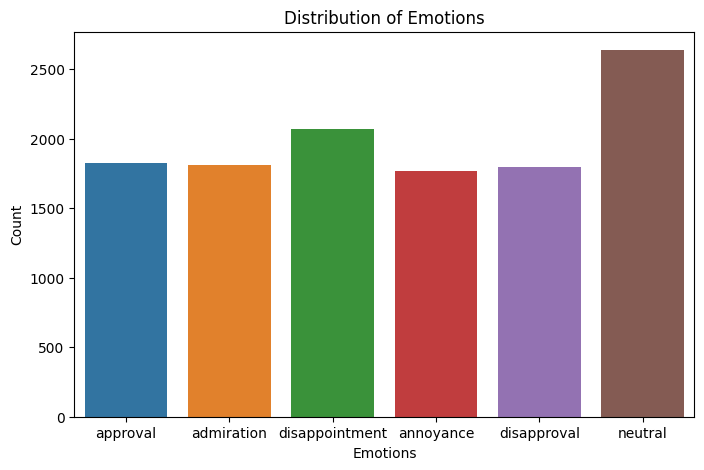

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(x=new_Train_Y1, ax=ax)

# Get the counts for each cluster label
value_counts = pd.Series(new_Train_Y1).value_counts()

for cluster_label, count in value_counts.items():
    emotion_label = label_mapping.get(cluster_label)

# Set x-axis labels to emotions
ax.set_xticklabels([label_mapping.get(cluster_label) for cluster_label in label_mapping.keys()])
plt.title('Distribution of Emotions')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()


# **Step 4:** Modeling


The aim of this project is only comparison, not fine-tuning, and so for that, we are going to use the **RandomForestClassifier** as the base model for all of our trials with its default values.

## `->` Modeling Comparison Without Class Reduction (13 classes)

### `0.` Create a Base Model For Tracking Improvments

### `->` Predicte Base Model (Main-class labels)

In [ ]:
lr = RandomForestClassifier(random_state = 42)

lr.fit(scaled_Train_X, Train_Y)
# predict the labels on Test dataset
predictions_lr = lr.predict(scaled_Test_X)

In [ ]:
f1 = f1_score(Test_Y, predictions_lr, average='weighted')
cm = confusion_matrix(Test_Y, predictions_lr)
print("F1 score is:", f1)

F1 score is: 0.8257564164303957


### `->` Predicte Base Model (Sub-class labels)

In [ ]:
clf_sent = RandomForestClassifier(random_state = 42)

clf_sent.fit(scaled_Train_X, Train_Y1)
# predict the labels on validation dataset
predictions_clf_sent = clf_sent.predict(scaled_Test_X)

In [ ]:
f1 = f1_score(Test_Y1, predictions_clf_sent, average='weighted')
print("F1 score is:", f1)

F1 score is: 0.543548656717049


### `1.` MultiOutputClassifier

In [ ]:
clf = RandomForestClassifier(random_state = 42)

In [ ]:
# Create a MultiOutputClassifier and specify the number of parallel jobs
multi_output_clf = MultiOutputClassifier(estimator=clf, n_jobs=2)

# Combine the target arrays into a single 2D array
combined_train_Y = np.column_stack((Train_Y, Encoded_Train_Y1))

# Fit the classifier with the combined target array
multi_output_clf.fit(scaled_Train_X, combined_train_Y)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42),
                      n_jobs=2)

In [ ]:
# Calculate accuracy for the test set
test_predictions = multi_output_clf.predict(scaled_Test_X)
test_accuracy_Y = f1_score(Test_Y, test_predictions[:, 0], average='weighted')
test_accuracy_Y1 = f1_score(Encoded_Test_Y1, test_predictions[:, 1], average='weighted')
test_accuracy = (test_accuracy_Y + test_accuracy_Y1) / 2

print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Accuracy: 70.51%


### `2.` Chain Classifier

In [ ]:
# Create a chain classifier using Logistic Regression as the base classifier
chain_classifier = ClassifierChain(clf)

# Combine Both Labels
combined_train_Y = np.column_stack((Train_Y, Encoded_Train_Y1))
combined_test_Y = np.column_stack((Test_Y, Encoded_Test_Y1))

# Fit the chain classifier on the combined targets
chain_classifier.fit(scaled_Train_X, combined_train_Y)

ClassifierChain(classifier=RandomForestClassifier(random_state=42),
                require_dense=[True, True])

In [ ]:
# Make predictions
predictions = chain_classifier.predict(scaled_Test_X)

# Access predictions for each target variable
y1_pred = predictions[:, 0]
y2_pred = predictions[:, 1]


In [ ]:
# Calculate accuracies (if needed)
y1_accuracy = f1_score(Test_Y, y1_pred.toarray(), average='weighted')
y2_accuracy = f1_score(Encoded_Test_Y1, y2_pred.toarray(), average='weighted')

# Print the predictions or use them for further analysis
print("First Target Variable - Test Accuracy: {:.2f}%".format(y1_accuracy * 100))
print("Second Target Variable - Test Accuracy: {:.2f}%".format(y2_accuracy * 100))


First Target Variable - Test Accuracy: 82.66%
Second Target Variable - Test Accuracy: 56.38%


## `->` Modeling Comparision (6 Classes)

### `0.` Create a Base Model For Tracking Improvments

### `->` Predicte Base Model (Main-class labels)

In [ ]:
lr = RandomForestClassifier(random_state = 42)

lr.fit(scaled_Train_X, Train_Y)
# predict the labels on Test dataset
predictions_lr = lr.predict(scaled_Test_X)

In [ ]:
f1 = f1_score(Test_Y, predictions_lr, average='weighted')
cm = confusion_matrix(Test_Y, predictions_lr)
print("F1 score is:", f1)

F1 score is: 0.8257564164303957


### `->` Predicte Base Model (Sub-class labels)

In [ ]:
clf_sent = RandomForestClassifier(random_state = 42)
clf_sent.fit(scaled_Train_X, new_Train_Y1)
# predict the labels on validation dataset
predictions_clf_sent = clf_sent.predict(scaled_Test_X)

In [ ]:
f1 = f1_score(new_Test_Y1, predictions_clf_sent, average='weighted')
print("F1 score is:", f1)

F1 score is: 0.6378829861716134


### `1.` MultiOutputClassifier

In [ ]:
clf = RandomForestClassifier(random_state = 42)

In [ ]:
# Create a MultiOutputClassifier and specify the number of parallel jobs
multi_output_clf = MultiOutputClassifier(estimator=clf, n_jobs=2)

# Combine the target arrays into a single 2D array
combined_train_Y = np.column_stack((Train_Y, new_Train_Y1))

# Fit the classifier with the combined target array
multi_output_clf.fit(scaled_Train_X, combined_train_Y)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42),
                      n_jobs=2)

In [ ]:
# Calculate accuracy for the test set
test_predictions = multi_output_clf.predict(scaled_Test_X)
test_accuracy_Y = f1_score(Test_Y, test_predictions[:, 0], average='weighted')
test_accuracy_Y1 = f1_score(new_Test_Y1, test_predictions[:, 1], average='weighted')
test_accuracy = (test_accuracy_Y + test_accuracy_Y1) / 2

print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Accuracy: 74.75%


### `2.` Chain Classifier

In [ ]:
combined_train_Y = np.column_stack((Train_Y, new_Train_Y1))

combined_test_Y = np.column_stack((Test_Y, new_Test_Y1))

# Create a chain classifier using Logistic Regression as the base classifier
chain_classifier = ClassifierChain(clf)

# Fit the chain classifier on the combined targets
chain_classifier.fit(scaled_Train_X, combined_train_Y)

ClassifierChain(classifier=RandomForestClassifier(random_state=42),
                require_dense=[True, True])

In [ ]:
# Make predictions
predictions = chain_classifier.predict(scaled_Test_X)

# Access predictions for each target variable
y1_pred = predictions[:, 0]
y2_pred = predictions[:, 1]


In [ ]:
# Calculate accuracies (if needed)
y1_accuracy = f1_score(Test_Y, y1_pred.toarray(), average='weighted')
y2_accuracy = f1_score(new_Test_Y1, y2_pred.toarray(), average='weighted')

# Print the predictions or use them for further analysis
print("First Target Variable - Test Accuracy: {:.2f}%".format(y1_accuracy * 100))
print("Second Target Variable - Test Accuracy: {:.2f}%".format(y2_accuracy * 100))


First Target Variable - Test Accuracy: 82.66%
Second Target Variable - Test Accuracy: 66.33%


# **Step 5:** Conclusion of the experiment


# To sum all the results up, we have :
________________________________________________________________________________



### `Modeling Comparison Without Class Reduction (Y2 = 13 Classes)`


In [ ]:

# |       Models               | Y1           | Y2          | AVG        |
# |-------------------         |-------       |-------      |-------     |
# | Random Forest Base Model   | 82.5%        |  54.3%      |   68.4%    |
# | MultiOutputClassifier      | 83.9%        |  57.1%      |   70.5%    |
# | ChainClassifier     	   | 82.6%        |  56.3%      |   69.4%    |



### `Modeling Comparison With Class Reduction (Y2 = 6 Classes)`




In [ ]:
# |       Models               | Y1           | Y2          | AVG     |
# |-------------------         |-------       |-------      |-------  |
# | Random Forest Base Model   | 82.5%        |  63.7%      |   73.1% |
# | MultiOutputClassifier      | 82.9%        |  66.5%	    |   74.7% |
# | ChainClassifier     	   | 82.6%        |  66.3%      |   74.4% |
